In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import copy
import time
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.model_selection import ShuffleSplit , KFold , StratifiedKFold , StratifiedShuffleSplit

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

In [5]:
def fun(str):
    return str.split('_')[1]
    

In [6]:
train = pd.read_csv('train.csv')

In [7]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
test = pd.read_csv('test.csv')

In [9]:
test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [10]:
train.drop('employee_id' , axis=1 , inplace = True)

In [11]:
id_ = test['employee_id']

In [12]:
train['department'] = LabelEncoder().fit_transform(train['department'])

In [13]:
test['department'] = LabelEncoder().fit_transform(test['department'])

In [14]:
train['education']= (train['education'].astype('category').cat.codes).replace(-1 , np.nan)

In [15]:
test['education']= (test['education'].astype('category').cat.codes).replace(-1 , np.nan)

In [16]:
train['recruitment_channel'] = LabelEncoder().fit_transform(train['recruitment_channel'])

In [17]:
test['recruitment_channel'] = LabelEncoder().fit_transform(test['recruitment_channel'])

In [18]:
train['gender'] = train['gender'].replace({'m':1,
                        'f':0})

In [19]:
test['gender'] = test['gender'].replace({'m':1,
                        'f':0})

In [20]:
train['region'] = train['region'].apply(fun).astype('int32')

In [21]:
test['region'] = test['region'].apply(fun).astype('int32')

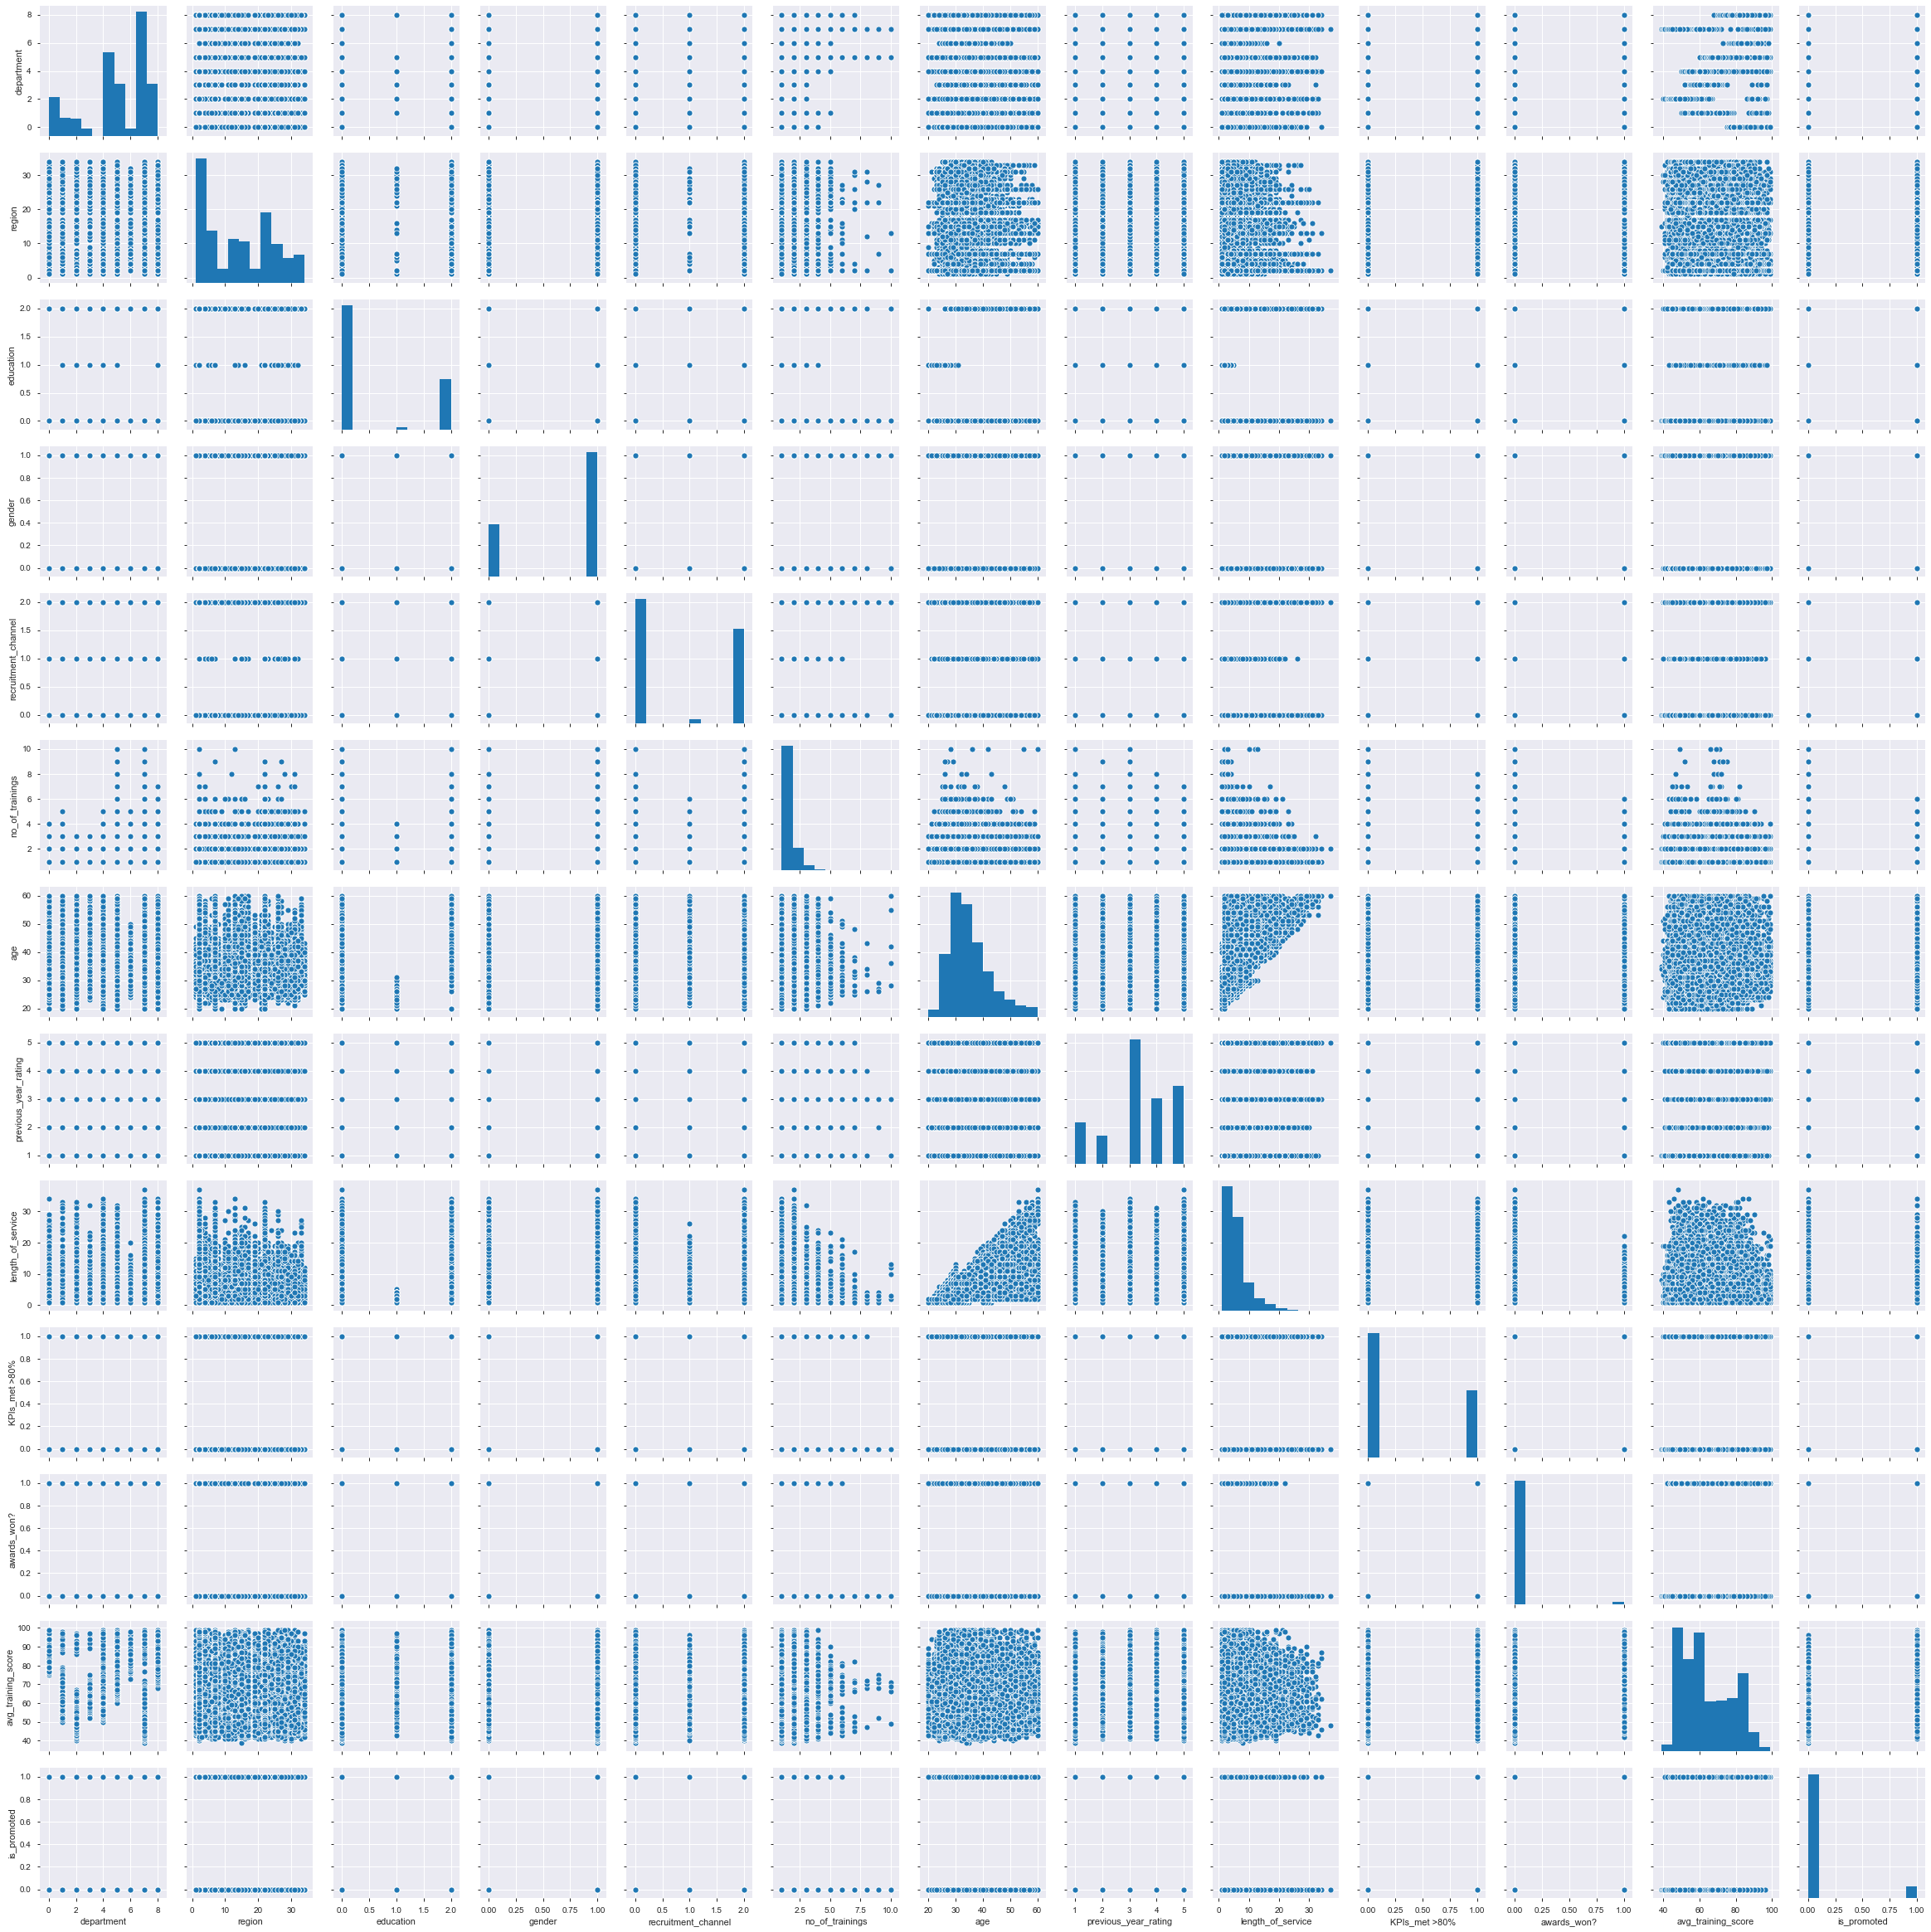

In [22]:
sns.pairplot(train)

In [ ]:
df = train.loc[:, ['department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score']]

imp = IterativeImputer(RandomForestClassifier(), max_iter=10, random_state=0)
df1 = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

In [ ]:
df_test = test.loc[:, ['department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score']]

imp = IterativeImputer(RandomForestClassifier(), max_iter=10, random_state=0)
df1_test = pd.DataFrame(imp.fit_transform(df_test), columns=df_test.columns)

In [ ]:
df1

In [ ]:
df1_test

In [ ]:
X = copy.deepcopy(df1)
                
y = train['is_promoted']


In [ ]:
Xtest = copy.deepcopy(df1_test)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [ ]:
index_tr = []
listoftrain = []

index_tt = []
listoftest = []


In [ ]:
print("KFold")
for train_index, test_index in kfold.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    for i in (train_index):
        index_tr.append(i)
        
    
    for j in (test_index):
        index_tt.append(j)
        


In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
a = list(chunks(index_tr, 43847))

In [ ]:
b = list(chunks(index_tt, 10963))

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
start = time.time()

f1 = 0
for i,j in zip(a,b):
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]
    clf = XGBClassifier(learning_rate=0.1, max_depth=4,n_estimators=200,max_delta_step=2,
                        min_child_weight=2, gamma=0.3, subsample=.6,scale_pos_weight=3,
                        seed=27, n_jobs = -1,predictor='gpu_predictor')
    clf.fit(X_train , y_train)
    ypred = clf.predict(X_test)
    
    f1 += f1_score(y_test , ypred)
print(f1/5)

end = time.time()
print(end-start)

In [ ]:
clf = XGBClassifier(learning_rate=0.1, max_depth=4,n_estimators=200,max_delta_step=2,
                        min_child_weight=2, gamma=0.3, subsample=.6,scale_pos_weight=3,
                        seed=27, n_jobs = -1,predictor='gpu_predictor')

In [ ]:
clf.fit(X,y)


In [ ]:
y_pred = clf.predict(Xtest)


In [ ]:
sub = pd.DataFrame()
sub['employee_id'] = id_
sub['is_promoted'] = y_pred
sub.to_csv('sub.csv' , index =False)